In [1]:
import numpy as np
import pandas as pd
import os
print(os.listdir("../input"))

['pretrained-bert-including-scripts', '1-preprocessing', 'jigsaw-unintended-bias-in-toxicity-classification', 'keras-bert-by-cyberzhg-github', 'bert-large-whole-word-masking']


**Copy All the files to working directory**

In [2]:
!cp -r '../input/keras-bert-by-cyberzhg-github/keras_bert/keras_bert' '/kaggle/working'
!cp -r '../input/keras-bert-by-cyberzhg-github/keras_bert/keras_pos_embd' '/kaggle/working'
!cp -r '../input/keras-bert-by-cyberzhg-github/keras_bert/keras_embed_sim' '/kaggle/working'
!cp -r '../input/keras-bert-by-cyberzhg-github/keras_bert/keras_position_wise_feed_forward' '/kaggle/working'
!cp -r '../input/keras-bert-by-cyberzhg-github/keras_bert/keras_layer_normalization' '/kaggle/working'
!cp -r '../input/keras-bert-by-cyberzhg-github/keras_bert/keras_self_attention' '/kaggle/working'
!cp -r '../input/keras-bert-by-cyberzhg-github/keras_bert/keras_multi_head' '/kaggle/working'
!cp -r '../input/keras-bert-by-cyberzhg-github/keras_bert/keras_transformer' '/kaggle/working'

In [3]:
import keras as keras
import keras.backend as K
from keras.models import load_model

from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

Using TensorFlow backend.


In [6]:
SEQ_LEN = 64
BATCH_SIZE = 128
EPOCHS = 1
LR = 1e-4

pretrained_path = '../input/pretrained-bert-including-scripts/uncased_L-12_H-768_A-12/uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = 'REVIEW_TEXT'
LABEL_COLUMN = 'LABEL'

**Get Tokenizer**

In [7]:
token_dict = load_vocabulary(vocab_path)
tokenizer = Tokenizer(token_dict)

In [68]:
tokenizer.tokenize("This is sample for tokenizer")

['[CLS]', 'this', 'is', 'sample', 'for', 'token', '##izer', '[SEP]']

**Load and Convert to data that BERT understand**

In [8]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    np.random.shuffle(items)
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

In [23]:
def load_data(data_df):
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

In [38]:
data = pd.read_csv("../input/1-preprocessing/data_df.csv",sep="\t")
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x:" ".join(eval(x)))
data.drop('PRODUCT_CATEGORY',axis=1,inplace=True)
data['RATING'] = data['RATING'].apply(lambda x: int(x>3))
data["LABEL"] = data["LABEL"].apply(lambda x: int(x==1))

ones = data[data["LABEL"]==1]
twos = data[data["LABEL"]==0]

train_data = ones[:7500]
train_data = train_data.append(twos[:7500])
val_data = ones[7500:8000]
val_data = val_data.append(twos[7500:8000])
test_data = ones[8000:]
test_data = test_data.append(twos[8000:])

train_data = train_data.sample(train_data.shape[0])
test_data = test_data.sample(test_data.shape[0])
val_data = val_data.sample(val_data.shape[0])

train_data.reset_index(inplace=True,drop=True)
test_data.reset_index(inplace=True,drop=True)
val_data.reset_index(inplace=True,drop=True)

In [50]:
train_x, train_y = load_data(train_data)
val_x, val_y = load_data(val_data)
test_x, test_y = load_data(test_data)
gc.collect()

100%|██████████| 15000/15000 [00:13<00:00, 1077.38it/s]


0

In [42]:
%%time
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,
)

**Create Keras Model and compile it**

In [43]:
inputs = model.inputs[:2]
dense = model.layers[-3].output
outputs = keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                             name = 'final_output')(dense)

decay_steps, warmup_steps = calc_train_steps(
    train_y.shape[0],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
)

model = keras.models.Model(inputs, outputs)
model.compile(
    AdamWarmup(decay_steps=decay_steps, warmup_steps=warmup_steps, lr=LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 64)           0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 64)           0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 64, 768), (3 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 64, 768)      1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [48]:
%%time
his = model.fit(
            train_x,
            train_y,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(val_x,val_y)
        )

Train on 15000 samples, validate on 1000 samples
Epoch 1/1
15000/15000 [==============================] - 122s 8ms/step - loss: 0.6656 - acc: 0.5845 - val_loss: 0.7021 - val_acc: 0.5690
CPU times: user 1min 24s, sys: 29.1 s, total: 1min 53s
Wall time: 2min 15s


In [49]:
%%time
model.fit(
        train_x,
        train_y,
        epochs=5,
        batch_size=BATCH_SIZE,
        initial_epoch=1,
        validation_data=(val_x,val_y))

Train on 15000 samples, validate on 1000 samples
Epoch 2/5
15000/15000 [==============================] - 100s 7ms/step - loss: 0.6266 - acc: 0.6494 - val_loss: 0.7021 - val_acc: 0.5690
Epoch 3/5
15000/15000 [==============================] - 100s 7ms/step - loss: 0.6260 - acc: 0.6481 - val_loss: 0.7021 - val_acc: 0.5690
Epoch 4/5
15000/15000 [==============================] - 100s 7ms/step - loss: 0.6268 - acc: 0.6469 - val_loss: 0.7021 - val_acc: 0.5690
Epoch 5/5
15000/15000 [==============================] - 100s 7ms/step - loss: 0.6269 - acc: 0.6478 - val_loss: 0.7021 - val_acc: 0.5690
CPU times: user 3min 15s, sys: 1min 51s, total: 5min 6s
Wall time: 6min 38s


In [51]:
def convert_test(test_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(test_df))):
        ids, segments = tokenizer.encode(test_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]


In [53]:
test_x = convert_test(test_data)
gc.collect()

100%|██████████| 5000/5000 [00:04<00:00, 1131.83it/s]


8

**Predict and Submit**

In [54]:
prediction = model.predict(test_x)

In [56]:
prediction = (prediction>0.5)

In [57]:
prediction = prediction.reshape(5000,1).astype(int)
np.unique(prediction , return_counts=True)

(array([0, 1]), array([1597, 3403]))

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

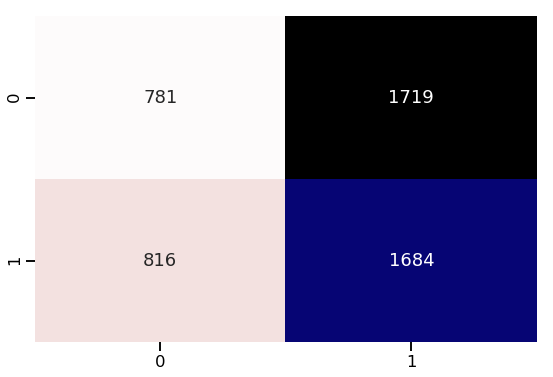

              precision    recall  f1-score   support

           0       0.49      0.31      0.38      2500
           1       0.49      0.67      0.57      2500

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.48      5000
weighted avg       0.49      0.49      0.48      5000



In [61]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(prediction)))
    plt.show()
    print(classification_report(y_true,y_pred))

heatconmat(test_y,prediction)

AUC score is:  0.493


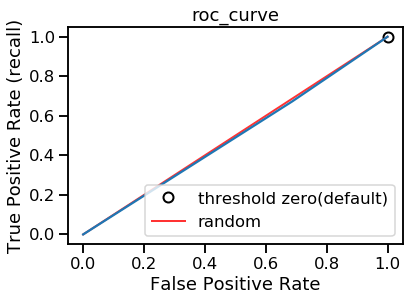

In [63]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_y, prediction)

# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))

plt.plot(fpr[close_zero], tpr[close_zero], 'o', 
         markersize=10, label="threshold zero(default)", fillstyle="none", c='k', mew=2)
plt.plot([0,1], linestyle='-', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.title("roc_curve");

from sklearn.metrics import auc
print("AUC score is: ", auc(fpr, tpr));

In [97]:
model.save("BERT.hdf5")